In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Solution to Exercise 4.10

In [2]:
# Define some manufactured solution

def u(x,t):
    return np.exp(-t)*np.cos(np.pi*x)

def u_x(x,t):
    return np.exp(-t)*(-np.pi)*np.sin(np.pi*x)

def u_xx(x,t):
    return -np.pi**2*u(x,t)

def u_t(x,t):
    return -u(x,t)

In [3]:
# Define the data and model parameters

def alpha(x,t):
    return 3+2*np.sin(3*np.pi*x)*np.exp(-t)

def alpha_x(x,t): # Used for manufactured solution only
    return 2*(3*np.pi)*np.cos(3*np.pi*x)*np.exp(-t)

def c(x,t):
    return x*np.cos(2*np.pi*t)

def q(x,t):
    return u_t(x,t)-(alpha(x,t)*u_xx(x,t)+alpha_x(x,t)*u_x(x,t)+c(x,t)*u_x(x,t))

def a(t):
    return np.exp(-t)

def b(t):
    return -np.exp(-t)

def f(x):
    return np.cos(np.pi*x)

In [ ]:
# Define the spatial domain and its discretization

ell_1 = 0.0
ell_2 = 1.0

n = 49 # number of interior points
x = np.linspace(ell_1,ell_2,n+2) # <----- ell_1 and ell_2 here
dx = x[1]-x[0]

x_mid = x[0:-1] + dx/2

In [ ]:
# Define an explicit method
r = 0.1 # <---- may need to change
dt = r*dx**2
print dt

v = np.copy(f(x)) # initialize v

t = 0 # initialize time

count = 0

# Initialize the matrix for approximating diffusion term, which changes with time
A = np.zeros((n,n))

# Initialize the matrix for approximating convection term
C = np.zeros((n,n))

# Initialize forcing vector
force = np.zeros(n)

while t<1: #<------------ 0.05
    # Construct the matrices
    for i in xrange(n):
        A[i,i] = - ( alpha(x[i+1],t) + alpha(x[i+2],t)/2 + alpha(x[i],t)/2 )
        if i == 0:
            A[i,i+1] = ( alpha(x[2],t) + alpha(x[1],t) ) / 2
        elif i == n-1:
            A[i,i-1] = ( alpha(x[-2],t) + alpha(x[-3],t) ) / 2
        else:
            A[i,i+1] = ( alpha(x[i+2],t) + alpha(x[i+1],t) ) / 2
            A[i,i-1] = ( alpha(x[i+1],t) + alpha(x[i],t) ) / 2
    A *= 1/dx**2

    for i in xrange(n):
        if i == 0:
            C[i,i+1] = c(x[1],t)
        elif i == n-1:
            C[i,i-1] = -c(x[-2],t)
        else:
            C[i,i+1] = c(x[i+1],t) 
            C[i,i-1] = -c(x[i+1],t)
    C *= 1./(2*dx)
    
    B = np.eye(n) + dt*(A+C) # <----- from forward Euler
    
    # Construct the forcing vector
    force[:] = q(x[1:-1],t)
    # Add in boundary effects
    force[0] += (alpha(x[0],t)+alpha(x[1],t))/2*a(t)/dx**2 - c(x[1],t)*a(t)/(2*dx)
    force[-1] += (alpha(x[-1],t)+alpha(x[-2],t))/2*b(t)/dx**2 + c(x[-2],t)*b(t)/(2*dx)
    # Multiply by dt
    force *= dt
    
    v[1:-1] = np.dot(B,v[1:-1]) + force
    
    t += dt #iterate time last
    
    v[0] = a(t)
    v[-1] = b(t)
    
    count += 1
    if count%500 == 0:
        plt.plot(x,v)

plt.figure(2)
plt.plot(x,v)
plt.plot(x,u(x,t),'r--')

4e-05


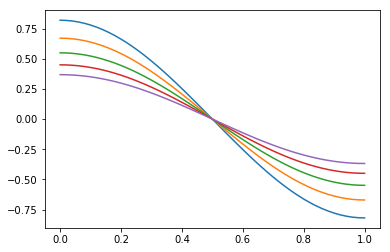

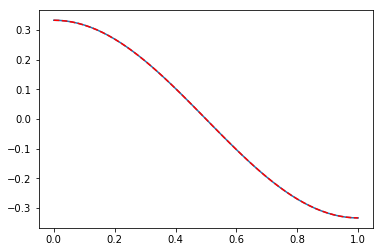

In [5]:
# Define an implicit method
#r = 0.1 # <---- may need to change
#dt = r*dx**2
dt = .1

v = np.copy(f(x)) # initialize v

t = 0 # initialize time

count = 0

# Initialize the matrix for approximating diffusion term, which changes with time
A = np.zeros((n,n))

# Initialize the matrix for approximating convection term
C = np.zeros((n,n))

# Initialize forcing vector
force = np.zeros(n)

while t<1:
    t += dt #iterate time first
    
    # Construct the matrices
    for i in xrange(n):
        A[i,i] = - ( alpha(x[i+1],t) + alpha(x[i+2],t)/2 + alpha(x[i],t)/2 )
        if i == 0:
            A[i,i+1] = ( alpha(x[2],t) + alpha(x[1],t) ) / 2
        elif i == n-1:
            A[i,i-1] = ( alpha(x[-2],t) + alpha(x[-3],t) ) / 2
        else:
            A[i,i+1] = ( alpha(x[i+2],t) + alpha(x[i+1],t) ) / 2
            A[i,i-1] = ( alpha(x[i+1],t) + alpha(x[i],t) ) / 2
    A *= 1/dx**2

    for i in xrange(n):
        if i == 0:
            C[i,i+1] = c(x[1],t)
        elif i == n-1:
            C[i,i-1] = -c(x[-2],t)
        else:
            C[i,i+1] = c(x[i+1],t) 
            C[i,i-1] = -c(x[i+1],t)
    C *= 1./(2*dx)
    
    B = np.eye(n) - dt*(A+C) # <----- from backward Euler
    B_inv = np.linalg.inv(B)
    
    # Construct the forcing vector
    force[:] = q(x[1:-1],t)
    # Add in boundary effects
    force[0] += (alpha(x[0],t)+alpha(x[1],t))/2*a(t)/dx**2 - c(x[1],t)*a(t)/(2*dx)
    force[-1] += (alpha(x[-1],t)+alpha(x[-2],t))/2*b(t)/dx**2 + c(x[-2],t)*b(t)/(2*dx)
    # Multiply by dt
    force *= dt
    
    v[1:-1] = np.dot(B_inv,v[1:-1] + force)
    
    v[0] = a(t)
    v[-1] = b(t)
    
    count += 1
    if count%2 == 0:
        plt.plot(x,v)

plt.figure(2)
plt.plot(x,v)
plt.plot(x,u(x,t),'r--')

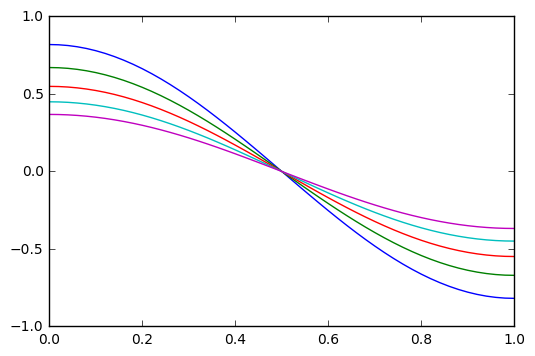

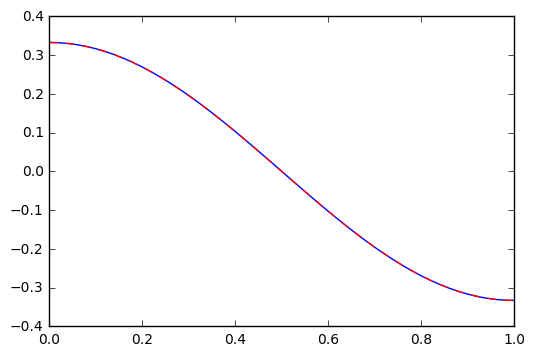

In [9]:
# Define an implicit method
#r = 0.1 # <---- may need to change
#dt = r*dx**2
dt = .1

v = np.copy(f(x)) # initialize v

t = 0 # initialize time

count = 0

# Initialize the matrix for approximating diffusion term, which changes with time
A = np.zeros((n,n))

# Initialize the matrix for approximating convection term
C = np.zeros((n,n))

# Initialize forcing vector
force = np.zeros(n)

while t<1:
    t += dt #iterate time first
    
    # Construct the matrices
    for i in xrange(n):
        A[i,i] = - ( alpha(x_mid[i],t) + alpha(x_mid[i+1],t) )
        if i == 0:
            A[i,i+1] = ( alpha(x_mid[i+1],t) )
        elif i == n-1:
            A[i,i-1] = ( alpha(x_mid[i],t) )
        else:
            A[i,i+1] = ( alpha(x_mid[i+1],t) )
            A[i,i-1] = ( alpha(x_mid[i],t) )
    A *= 1/dx**2

    for i in xrange(n):
        if i == 0:
            C[i,i+1] = c(x[1],t)
        elif i == n-1:
            C[i,i-1] = -c(x[-2],t)
        else:
            C[i,i+1] = c(x[i+1],t) 
            C[i,i-1] = -c(x[i+1],t)
    C *= 1./(2*dx)
    
    B = np.eye(n) - dt*(A+C) # <----- from backward Euler
    B_inv = np.linalg.inv(B)
    
    # Construct the forcing vector
    force[:] = q(x[1:-1],t)
    # Add in boundary effects
    force[0] += (alpha(x_mid[0],t))*a(t)/dx**2 - c(x[1],t)*a(t)/(2*dx)
    force[-1] += (alpha(x_mid[-1],t))*b(t)/dx**2 + c(x[-2],t)*b(t)/(2*dx)
    # Multiply by dt
    force *= dt
    
    v[1:-1] = np.dot(B_inv,v[1:-1] + force)
    
    v[0] = a(t)
    v[-1] = b(t)
    
    count += 1
    if count%2 == 0:
        plt.plot(x,v)

plt.figure(2)
plt.plot(x,v)
plt.plot(x,u(x,t),'r--')